Build a semantic search engine

This tutorial will familiarize you with LangChain's document loader, embedding, and vector store abstractions. These abstractions are designed to support retrieval of data-- from (vector) databases and other sources-- for integration with LLM workflows. They are important for applications that fetch data to be reasoned over as part of model inference, as in the case of retrieval-augmented generation, or RAG (see our RAG tutorial here).

Here we will build a search engine over a PDF document. This will allow us to retrieve passages in the PDF that are similar to an input query.

Context window
A chat model's context window refers to the maximum size of the input sequence the model can process at one time. While the context windows of modern LLMs are quite large, they still present a limitation that developers must keep in mind when working with chat models.

In [1]:
from dotenv import load_dotenv
import os
load_dotenv()
import getpass
import os
from langchain_groq import ChatGroq
os.environ["GROQ_API_KEY"] = os.environ['groqe_api_key']
model = ChatGroq(model="llama3-8b-8192")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.environ["langchain_api_key"]

In [11]:
from langchain_core.documents import Document

documents = [
    Document(
        page_content="Dogs are great companions, known for their loyalty and friendliness.",
        metadata={"source": "mammal-pets-doc"},
    ),
    Document(
        page_content="Cats are independent pets that often enjoy their own space.",
        metadata={"source": "mammal-pets-doc"},
    ),
]

In [12]:
from langchain_community.document_loaders import PyPDFLoader

In [13]:
file_path = "../PINN/pinn.pdf"

In [14]:
loader = PyPDFLoader(file_path)

In [15]:
docs = loader.load()

In [16]:
docs

[Document(metadata={'source': '../PINN/pinn.pdf', 'page': 0}, page_content='What Are Physics-Informed Neural Networks\n(PINNs)?\nPhysics-informed neural networks (PINNs) are neural networks that incorporate\nphysical laws described by differential equations into their loss functions to guide\nthe learning process toward solutions that are more consistent with the underlying\nphysics. PINNs can be used to:\nApproximate solutions to partial differential equations (PDEs) and ordinary\ndifferential equations (ODEs).\nSolve inverse problems, such as estimating model parameters from limited data.\nWith Deep Learning Toolbox™, you can build and train PINNs, which enable rapid\npredictive analysis. You can integrate PINNs with MATLAB  and Simulink for\nsystem-level simulation, control design, and design optimization.\nThe Bene\x00ts of PINNs\nPINNs are a class of physics-informed machine learning methods that seamlessly\nintegrate physics knowledge with data. Often, PINNs get compared with pur

In [17]:
docs[0]

Document(metadata={'source': '../PINN/pinn.pdf', 'page': 0}, page_content='What Are Physics-Informed Neural Networks\n(PINNs)?\nPhysics-informed neural networks (PINNs) are neural networks that incorporate\nphysical laws described by differential equations into their loss functions to guide\nthe learning process toward solutions that are more consistent with the underlying\nphysics. PINNs can be used to:\nApproximate solutions to partial differential equations (PDEs) and ordinary\ndifferential equations (ODEs).\nSolve inverse problems, such as estimating model parameters from limited data.\nWith Deep Learning Toolbox™, you can build and train PINNs, which enable rapid\npredictive analysis. You can integrate PINNs with MATLAB  and Simulink for\nsystem-level simulation, control design, and design optimization.\nThe Bene\x00ts of PINNs\nPINNs are a class of physics-informed machine learning methods that seamlessly\nintegrate physics knowledge with data. Often, PINNs get compared with pure

In [18]:
docs[0].page_content

'What Are Physics-Informed Neural Networks\n(PINNs)?\nPhysics-informed neural networks (PINNs) are neural networks that incorporate\nphysical laws described by differential equations into their loss functions to guide\nthe learning process toward solutions that are more consistent with the underlying\nphysics. PINNs can be used to:\nApproximate solutions to partial differential equations (PDEs) and ordinary\ndifferential equations (ODEs).\nSolve inverse problems, such as estimating model parameters from limited data.\nWith Deep Learning Toolbox™, you can build and train PINNs, which enable rapid\npredictive analysis. You can integrate PINNs with MATLAB  and Simulink for\nsystem-level simulation, control design, and design optimization.\nThe Bene\x00ts of PINNs\nPINNs are a class of physics-informed machine learning methods that seamlessly\nintegrate physics knowledge with data. Often, PINNs get compared with purely\ndata-driven methods and traditional numerical methods for solving prob

In [19]:

print(len(docs))

8


In [20]:
print(f"{docs[0].page_content[:200]}\n")

What Are Physics-Informed Neural Networks
(PINNs)?
Physics-informed neural networks (PINNs) are neural networks that incorporate
physical laws described by differential equations into their loss funct



In [21]:
print(docs[0].metadata)

{'source': '../PINN/pinn.pdf', 'page': 0}


Splitting

For both information retrieval and downstream question-answering purposes, a page may be too coarse a representation. Our goal in the end will be to retrieve Document objects that answer an input query, and further splitting our PDF will help ensure that the meanings of relevant portions of the document are not "washed out" by surrounding text.

We can use text splitters for this purpose. Here we will use a simple text splitter that partitions based on characters. We will split our documents into chunks of 1000 characters with 200 characters of overlap between chunks. The overlap helps mitigate the possibility of separating a statement from important context related to it. We use the RecursiveCharacterTextSplitter,

In [3]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [22]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200, add_start_index=True
)

In [23]:
all_splits = text_splitter.split_documents(docs)

In [24]:
len(all_splits)

19

In [25]:
all_splits[0].page_content

'What Are Physics-Informed Neural Networks\n(PINNs)?\nPhysics-informed neural networks (PINNs) are neural networks that incorporate\nphysical laws described by differential equations into their loss functions to guide\nthe learning process toward solutions that are more consistent with the underlying\nphysics. PINNs can be used to:\nApproximate solutions to partial differential equations (PDEs) and ordinary\ndifferential equations (ODEs).\nSolve inverse problems, such as estimating model parameters from limited data.\nWith Deep Learning Toolbox™, you can build and train PINNs, which enable rapid\npredictive analysis. You can integrate PINNs with MATLAB  and Simulink for\nsystem-level simulation, control design, and design optimization.\nThe Bene\x00ts of PINNs\nPINNs are a class of physics-informed machine learning methods that seamlessly\nintegrate physics knowledge with data. Often, PINNs get compared with purely\ndata-driven methods and traditional numerical methods for solving prob

Embeddings

Vector search is a common way to store and search over unstructured data (such as unstructured text). The idea is to store numeric vectors that are associated with the text. Given a query, we can embed it as a vector of the same dimension and use vector similarity metrics (such as cosine similarity) to identify related text.

In [2]:
from langchain import HuggingFaceHub, LLMChain
from langchain.llms import HuggingFaceHub
from langchain.embeddings import HuggingFaceEmbeddings

In [5]:
model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
hf = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_8268\222227050.py:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  hf = HuggingFaceEmbeddings(
d:\a27_YEARS_OLD\ml_tools\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
vector_1 = hf.embed_query(all_splits[0].page_content)

In [30]:
vector_2 = hf.embed_query(all_splits[1].page_content)

In [27]:
vector_1[:10]

[-0.0715692937374115,
 0.0017664708429947495,
 -0.028964493423700333,
 0.04613699018955231,
 -0.010813171043992043,
 -0.013639668934047222,
 0.03892967477440834,
 -0.031606171280145645,
 -0.053929612040519714,
 0.0413188673555851]

In [31]:
vector_2[:10]

[-0.06952766329050064,
 0.03859901800751686,
 -0.03218096122145653,
 0.03741441294550896,
 -0.002060369122773409,
 -0.024099301546812057,
 0.03414832055568695,
 -0.02780420146882534,
 -0.04422292113304138,
 0.05092946067452431]

In [32]:
assert len(vector_1) == len(vector_2)

In [33]:
print(f"Generated vectors of length {len(vector_1)}\n")

Generated vectors of length 768



Vector stores

LangChain VectorStore objects contain methods for adding text and Document objects to the store, and querying them using various similarity metrics. They are often initialized with embedding models, which determine how text data is translated to numeric vectors.

LangChain includes a suite of integrations with different vector store technologies. Some vector stores are hosted by a provider (e.g., various cloud providers) and require specific credentials to use; some (such as Postgres) run in separate infrastructure that can be run locally or via a third-party; others can run in-memory for lightweight workloads. Let's select a vector store:

In [26]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(hf)

In [27]:
ids = vector_store.add_documents(documents=all_splits)

Embeddings typically represent text as a "dense" vector such that texts with similar meanings are gemoetrically close. This lets us retrieve relevant information just by passing in a question, without knowledge of any specific key-terms used in the document.

Return documents based on similarity to a string query:

In [28]:
results = vector_store.similarity_search(
    "How pinns differ from traditional neural network ?"
)

print(results[0])

page_content='provides more information to the PINN without the need for more measurements.
While this toy example can be solved analytically, it illustrates the concepts behind
PINNs.
A naïve neural network, trained using the trainnet function in Deep Learning Toolbox, over ts
noisy measurements and performs poorly for t  outside of available range. (See MATLAB code.)
θ
′′
(t)+2βθ′(t)+ω20θ(t)=0
11/28/24, 7:04 PM What Are Physics-Informed Neural Networks (PINNs)? - MATLAB & Simulink
https://in.mathworks.com/discovery/physics-informed-neural-networks.html 4/8' metadata={'source': '../PINN/pinn.pdf', 'page': 3, 'start_index': 820}


In [37]:
results

[Document(id='7507cb3f-40b6-4243-a14e-9cf56c378d6d', metadata={'source': '../PINN/pinn.pdf', 'page': 3, 'start_index': 820}, page_content='provides more information to the PINN without the need for more measurements.\nWhile this toy example can be solved analytically, it illustrates the concepts behind\nPINNs.\nA naïve neural network, trained using the trainnet function in Deep Learning Toolbox, over\x00ts\nnoisy measurements and performs poorly for t  outside of available range. (See MATLAB code.)\nθ\n′′\n(t)+2βθ′(t)+ω20θ(t)=0\n11/28/24, 7:04 PM What Are Physics-Informed Neural Networks (PINNs)? - MATLAB & Simulink\nhttps://in.mathworks.com/discovery/physics-informed-neural-networks.html 4/8'),
 Document(id='c2dd13a7-ec82-43ba-80f7-537935d7c078', metadata={'source': '../PINN/pinn.pdf', 'page': 5, 'start_index': 0}, page_content='PINNs have loss functions, , which consist of several terms: the physics-informed\nloss term, , and optionally terms that evaluate the error between the value

In [39]:
results = await vector_store.asimilarity_search("PINN Applications")

print(results[0])

page_content='provides more information to the PINN without the need for more measurements.
While this toy example can be solved analytically, it illustrates the concepts behind
PINNs.
A naïve neural network, trained using the trainnet function in Deep Learning Toolbox, over ts
noisy measurements and performs poorly for t  outside of available range. (See MATLAB code.)
θ
′′
(t)+2βθ′(t)+ω20θ(t)=0
11/28/24, 7:04 PM What Are Physics-Informed Neural Networks (PINNs)? - MATLAB & Simulink
https://in.mathworks.com/discovery/physics-informed-neural-networks.html 4/8' metadata={'source': '../PINN/pinn.pdf', 'page': 3, 'start_index': 820}


In [40]:
# Note that providers implement different scores; the score here
# is a distance metric that varies inversely with similarity.

results = vector_store.similarity_search_with_score("What Are Physics-Informed Neural Networks(PINNs)?")
doc, score = results[0]
print(f"Score: {score}\n")
print(doc)

Score: 0.8858522080646115

page_content='What Are Physics-Informed Neural Networks
(PINNs)?
Physics-informed neural networks (PINNs) are neural networks that incorporate
physical laws described by differential equations into their loss functions to guide
the learning process toward solutions that are more consistent with the underlying
physics. PINNs can be used to:
Approximate solutions to partial differential equations (PDEs) and ordinary
differential equations (ODEs).
Solve inverse problems, such as estimating model parameters from limited data.
With Deep Learning Toolbox™, you can build and train PINNs, which enable rapid
predictive analysis. You can integrate PINNs with MATLAB  and Simulink for
system-level simulation, control design, and design optimization.
The Bene ts of PINNs
PINNs are a class of physics-informed machine learning methods that seamlessly
integrate physics knowledge with data. Often, PINNs get compared with purely
data-driven methods and traditional numerical me

In [41]:
embedding = hf.embed_query("How PINNs Work")

results = vector_store.similarity_search_by_vector(embedding)
print(results[0])

page_content='provides more information to the PINN without the need for more measurements.
While this toy example can be solved analytically, it illustrates the concepts behind
PINNs.
A naïve neural network, trained using the trainnet function in Deep Learning Toolbox, over ts
noisy measurements and performs poorly for t  outside of available range. (See MATLAB code.)
θ
′′
(t)+2βθ′(t)+ω20θ(t)=0
11/28/24, 7:04 PM What Are Physics-Informed Neural Networks (PINNs)? - MATLAB & Simulink
https://in.mathworks.com/discovery/physics-informed-neural-networks.html 4/8' metadata={'source': '../PINN/pinn.pdf', 'page': 3, 'start_index': 820}


In [42]:
from typing import List

from langchain_core.documents import Document
from langchain_core.runnables import chain


@chain
def retriever(query: str) -> List[Document]:
    return vector_store.similarity_search(query, k=1)


retriever.batch(
    [
        "PINN Applications?",
        # "When was Nike incorporated?",
    ],
)

[[Document(id='7db90e82-31ea-494d-a9d1-2e842499e3b2', metadata={'source': '../PINN/pinn.pdf', 'page': 6, 'start_index': 0}, page_content='PINN Applications\nPINNs leverage the power of deep learning while improving compliance with\nphysical laws, making them a versatile tool for applications where physics is fully or\npartially known, such as the case of a PDE or ODE with unknown coe\x00cients.\nApplications of PINNs include:\nHeat transfer, speci\x00cally for modeling heat distribution and transfer processes.\nPINNs can embed the governing equations that model thermal processes in\nmaterials and systems, such as the heat equation, into the loss function. This\napproach ensures that the solutions adhere to these physical laws, leading to\nphysically plausible predictions. In addition, PINNs can replace expensive\nnumerical simulations to quickly approximate temperature distributions over\nparameterized geometries in design optimization applications. Furthermore,\nPINNs can be used in i

In [43]:
retriever = vector_store.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 1},
)

retriever.batch(
    [
        "PINN Applications??",
        # "When was Nike incorporated?",
    ],
)

[[Document(id='7db90e82-31ea-494d-a9d1-2e842499e3b2', metadata={'source': '../PINN/pinn.pdf', 'page': 6, 'start_index': 0}, page_content='PINN Applications\nPINNs leverage the power of deep learning while improving compliance with\nphysical laws, making them a versatile tool for applications where physics is fully or\npartially known, such as the case of a PDE or ODE with unknown coe\x00cients.\nApplications of PINNs include:\nHeat transfer, speci\x00cally for modeling heat distribution and transfer processes.\nPINNs can embed the governing equations that model thermal processes in\nmaterials and systems, such as the heat equation, into the loss function. This\napproach ensures that the solutions adhere to these physical laws, leading to\nphysically plausible predictions. In addition, PINNs can replace expensive\nnumerical simulations to quickly approximate temperature distributions over\nparameterized geometries in design optimization applications. Furthermore,\nPINNs can be used in i

Embedding models

Imagine being able to capture the essence of any text - a tweet, document, or book - in a single, compact representation. This is the power of embedding models, which lie at the heart of many retrieval systems. Embedding models transform human language into a format that machines can understand and compare with speed and accuracy. These models take text as input and produce a fixed-length array of numbers, a numerical fingerprint of the text's semantic meaning. Embeddings allow search system to find relevant documents not just based on keyword matches, but on semantic understanding.

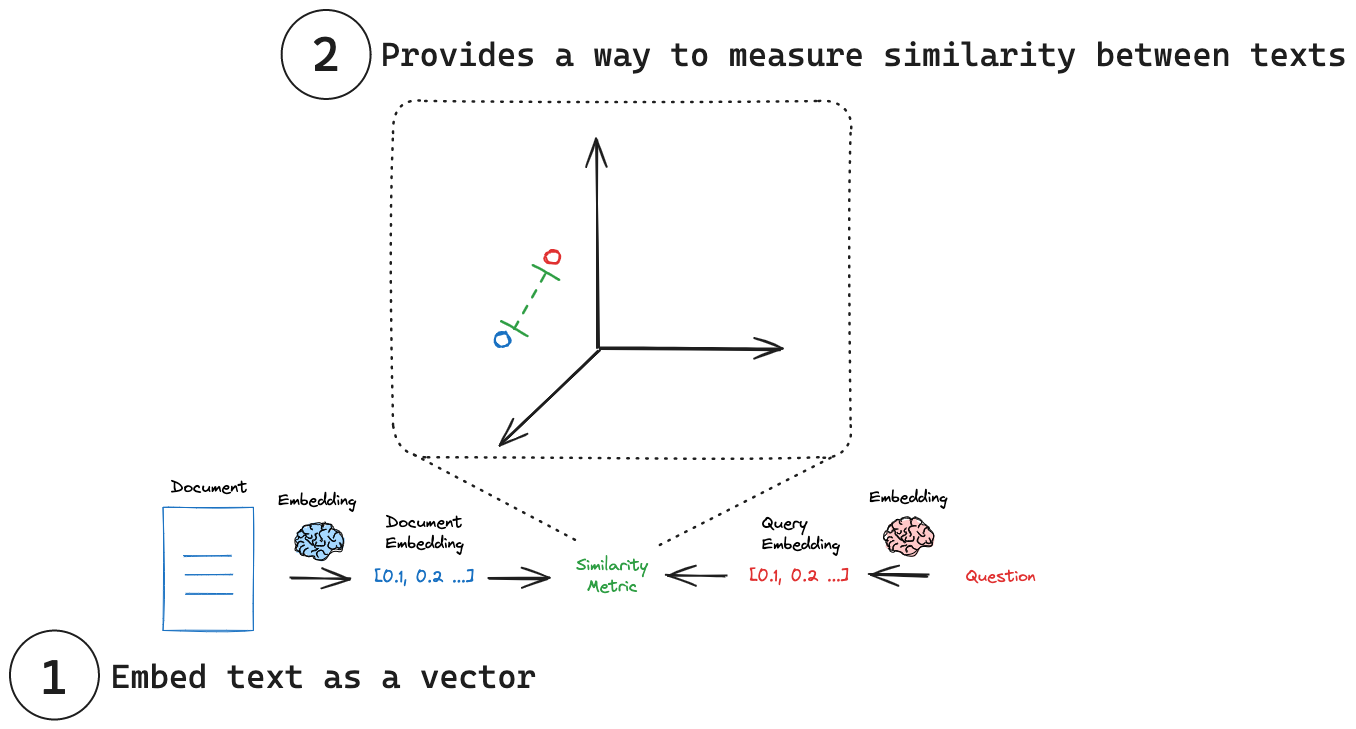

(1) Embed text as a vector: Embeddings transform text into a numerical vector representation.

(2) Measure similarity: Embedding vectors can be compared using simple mathematical operations.

In [6]:
embeddings = hf.embed_documents(
    [
        "Hi there!",
        "Oh, hello!",
        "What's your name?",
        "My friends call me World",
        "Hello World!"
    ]
)
len(embeddings), len(embeddings[0])

(5, 768)

In [8]:
embeddings[0]

[0.04065161943435669,
 0.038614071905612946,
 -0.023672472685575485,
 0.044803690165281296,
 0.06722123920917511,
 -0.03028140217065811,
 0.0023202334996312857,
 0.05043645575642586,
 0.04003790020942688,
 -0.008837743662297726,
 -0.00949073489755392,
 -0.02862350083887577,
 -0.013932802714407444,
 0.014657755382359028,
 0.008816352114081383,
 -0.024240151047706604,
 0.049497008323669434,
 -0.02183101512491703,
 -0.025835344567894936,
 0.011732683517038822,
 0.026901545003056526,
 0.027565618976950645,
 0.006897850893437862,
 0.055878717452287674,
 -0.00042815765482373536,
 0.04185901954770088,
 -0.023439744487404823,
 -0.014832466840744019,
 0.01464651245623827,
 0.02200741320848465,
 0.008454762399196625,
 -0.00968104973435402,
 0.015049046836793423,
 0.0846736952662468,
 2.078747911582468e-06,
 0.029706431552767754,
 -0.00966739747673273,
 0.004832613281905651,
 0.011734447441995144,
 0.05281313136219978,
 -0.020353663712739944,
 0.035156071186065674,
 -0.013267255388200283,
 0.0282

In [ ]:
query_embedding = hf.embed_query("What is the meaning of life?")

In [30]:
query_embedding

[-0.02442421205341816,
 -0.028136661276221275,
 -0.035564254969358444,
 0.018383817747235298,
 -0.0690055638551712,
 -0.026514841243624687,
 0.05478359013795853,
 -0.041990797966718674,
 -0.0982377752661705,
 0.041225649416446686,
 -0.016675738617777824,
 0.018111618235707283,
 0.01654779352247715,
 0.02041453868150711,
 0.07629753649234772,
 0.002447115257382393,
 -0.0015381134580820799,
 0.01358308270573616,
 -0.021547656506299973,
 -0.020261818543076515,
 0.022714262828230858,
 -0.004203224554657936,
 -0.02742510475218296,
 0.03096824139356613,
 0.0068268245086073875,
 0.006844395771622658,
 -0.02215149626135826,
 -0.03162997588515282,
 -0.033086180686950684,
 -0.005600317381322384,
 0.0045303781516849995,
 -0.0450136698782444,
 0.03703302517533302,
 0.05323173850774765,
 1.523778450973623e-06,
 0.01563791185617447,
 0.03438268229365349,
 -0.0005378542700782418,
 0.03236529603600502,
 0.05392012000083923,
 -0.04540069401264191,
 0.03511599451303482,
 0.03977671265602112,
 -0.0032890

Measure similarity

Each embedding is essentially a set of coordinates, often in a high-dimensional space. In this space, the position of each point (embedding) reflects the meaning of its corresponding text. Just as similar words might be close to each other in a thesaurus, similar concepts end up close to each other in this embedding space. This allows for intuitive comparisons between different pieces of text. By reducing text to these numerical representations, we can use simple mathematical operations to quickly measure how alike two pieces of text are, regardless of their original length or structure. Some common similarity metrics include:

Cosine Similarity: Measures the cosine of the angle between two vectors.

Euclidean Distance: Measures the straight-line distance between two points.

Dot Product: Measures the projection of one vector onto another.

In [ ]:
query_embedding = hf.embed_query("How pinns differ from traditional neural network?")

In [32]:
query_embedding

[-0.02442421205341816,
 -0.028136661276221275,
 -0.035564254969358444,
 0.018383817747235298,
 -0.0690055638551712,
 -0.026514841243624687,
 0.05478359013795853,
 -0.041990797966718674,
 -0.0982377752661705,
 0.041225649416446686,
 -0.016675738617777824,
 0.018111618235707283,
 0.01654779352247715,
 0.02041453868150711,
 0.07629753649234772,
 0.002447115257382393,
 -0.0015381134580820799,
 0.01358308270573616,
 -0.021547656506299973,
 -0.020261818543076515,
 0.022714262828230858,
 -0.004203224554657936,
 -0.02742510475218296,
 0.03096824139356613,
 0.0068268245086073875,
 0.006844395771622658,
 -0.02215149626135826,
 -0.03162997588515282,
 -0.033086180686950684,
 -0.005600317381322384,
 0.0045303781516849995,
 -0.0450136698782444,
 0.03703302517533302,
 0.05323173850774765,
 1.523778450973623e-06,
 0.01563791185617447,
 0.03438268229365349,
 -0.0005378542700782418,
 0.03236529603600502,
 0.05392012000083923,
 -0.04540069401264191,
 0.03511599451303482,
 0.03977671265602112,
 -0.0032890

In [40]:
results

[Document(id='ead2a060-f658-41ee-a692-9538aa2479b0', metadata={'source': '../PINN/pinn.pdf', 'page': 3, 'start_index': 820}, page_content='provides more information to the PINN without the need for more measurements.\nWhile this toy example can be solved analytically, it illustrates the concepts behind\nPINNs.\nA naïve neural network, trained using the trainnet function in Deep Learning Toolbox, over\x00ts\nnoisy measurements and performs poorly for t  outside of available range. (See MATLAB code.)\nθ\n′′\n(t)+2βθ′(t)+ω20θ(t)=0\n11/28/24, 7:04 PM What Are Physics-Informed Neural Networks (PINNs)? - MATLAB & Simulink\nhttps://in.mathworks.com/discovery/physics-informed-neural-networks.html 4/8'),
 Document(id='85726967-b41f-4da9-9c30-97d59d067dee', metadata={'source': '../PINN/pinn.pdf', 'page': 5, 'start_index': 0}, page_content='PINNs have loss functions, , which consist of several terms: the physics-informed\nloss term, , and optionally terms that evaluate the error between the value

In [41]:
results[0].page_content

'provides more information to the PINN without the need for more measurements.\nWhile this toy example can be solved analytically, it illustrates the concepts behind\nPINNs.\nA naïve neural network, trained using the trainnet function in Deep Learning Toolbox, over\x00ts\nnoisy measurements and performs poorly for t  outside of available range. (See MATLAB code.)\nθ\n′′\n(t)+2βθ′(t)+ω20θ(t)=0\n11/28/24, 7:04 PM What Are Physics-Informed Neural Networks (PINNs)? - MATLAB & Simulink\nhttps://in.mathworks.com/discovery/physics-informed-neural-networks.html 4/8'

In [42]:
results_embedding = hf.embed_query(results[0].page_content)

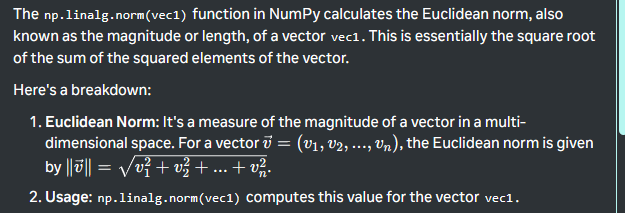

In [43]:
import numpy as np

def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2) # a.b = |a||b|cos(theta) > cos(theta) = a.b/|a||b|

similarity = cosine_similarity(query_embedding, results_embedding)
print("Cosine Similarity:", similarity)

Cosine Similarity: 0.7014545503005907



Vector stores

 are specialized data stores that enable indexing and retrieving information based on vector representations.

These vectors, called embeddings, capture the semantic meaning of data that has been embedded.

Vector stores are frequently used to search over unstructured data, such as text, images, and audio, to retrieve relevant information based on semantic similarity rather than exact keyword matches.

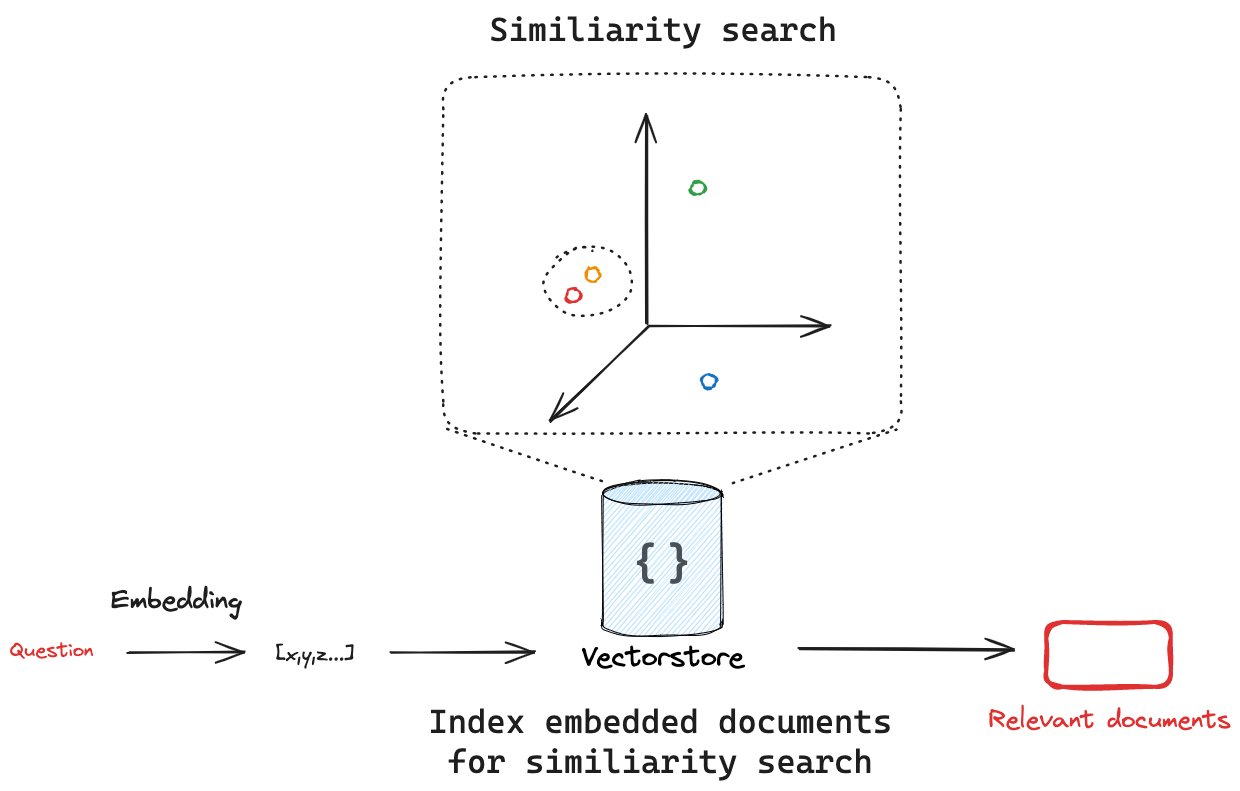